In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
gpytorch.functions.use_toeplitz = False

%matplotlib inline


Bad key "hatch.linewidth" on line 54 in
/home/gpleiss/.dotfiles/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)
train_x = train_x.cuda()
train_y = train_y.cuda()

In [3]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(0, 1)])
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


likelihood = GaussianLikelihood().cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

In [4]:
# Optimize the model
model.train()
likelihood.train()

optimizer = optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)
optimizer.n_iter = 0

def train():
    for i in range(30):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -model.marginal_log_likelihood(likelihood, output, train_y)
        loss.backward()
        optimizer.n_iter += 1
        print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
        optimizer.step()
%time train()

Iter 1/30 - Loss: 1.151
Iter 2/30 - Loss: 1.102
Iter 3/30 - Loss: 1.051
Iter 4/30 - Loss: 1.015
Iter 5/30 - Loss: 0.987
Iter 6/30 - Loss: 0.975
Iter 7/30 - Loss: 0.970
Iter 8/30 - Loss: 0.966
Iter 9/30 - Loss: 0.955
Iter 10/30 - Loss: 0.938
Iter 11/30 - Loss: 0.913
Iter 12/30 - Loss: 0.886
Iter 13/30 - Loss: 0.858
Iter 14/30 - Loss: 0.823
Iter 15/30 - Loss: 0.788
Iter 16/30 - Loss: 0.733
Iter 17/30 - Loss: 0.660
Iter 18/30 - Loss: 0.568
Iter 19/30 - Loss: 0.465
Iter 20/30 - Loss: 0.347
Iter 21/30 - Loss: 0.224
Iter 22/30 - Loss: 0.123
Iter 23/30 - Loss: 0.032
Iter 24/30 - Loss: -0.044
Iter 25/30 - Loss: -0.090
Iter 26/30 - Loss: -0.116
Iter 27/30 - Loss: -0.117
Iter 28/30 - Loss: -0.103
Iter 29/30 - Loss: -0.087
Iter 30/30 - Loss: -0.084
CPU times: user 1.32 s, sys: 96 ms, total: 1.42 s
Wall time: 1.42 s


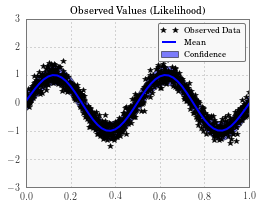

In [5]:
model.eval()
likelihood.eval()

f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
test_x = Variable(torch.linspace(0, 1, 51)).cuda()
observed_pred = likelihood(model(test_x))

def ax_plot(ax, rand_var, title):
    lower, upper = rand_var.confidence_region()
    ax.plot(train_x.data.cpu().numpy(), train_y.data.cpu().numpy(), 'k*')
    ax.plot(test_x.data.cpu().numpy(), rand_var.mean().data.cpu().numpy(), 'b')
    ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')